## Import our favoritest friends ever...the double trouble!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Define our function 

In [2]:
def dfdx(x,f): 
    
    y = f[0] #set y as the first fn
    z = f[1] #set z as the second fn, equivalent to the 2nd derivative 
    dydx = np.zeros_like(f) 
    dydx[0] = z #first derivative 
    dydx[1] = -1*y #second derivative
    
    return dydx

## Define the cash karp core 

In [3]:
def cash_karp_core_mv(x_i,y_i,nv,h,f):
    
    #define array
    #side note - I had originally written each k value out with each value and then realized it was really easy to make mistakes
    #brant's way of doing this has way less room for mistakes
    
    ni = 7 
    nj = 6
    ci = np.zeros(ni)
    aij = np.zeros((ni,nj))
    bi = np.zeros(ni)
    bis = np.zeros(ni)
    
    #write all the constants 
    
    ci[2] = 1./5. 
    ci[3] = 3./10.
    ci[4] = 3./5.
    ci[5] = 1.
    ci[6] = 7./8.
    
    aij[2,1] = 1./5
    aij[3,1] = 3./40.
    aij[4,1] = 3./10
    aij[5,1] = -11./54.
    aij[6,1] = 1631./55296.
    
    aij[3,2] = 9./40.
    aij[4,2] = -9./10.
    aij[5,2] = 5./2.
    aij[6,2] = 175./512.
    
    aij[4,3] = 6./5.
    aij[5,3] = -70./27.
    aij[6,3] = 575./13824.
    
    aij[5,4] = 35./27.
    aij[6,4] = 44275./110592.
    
    aij[6,5] = 253./4096.
    
    bi[1] = 37./378.
    bi[2] = 0.
    bi[3] = 250./621.
    bi[4] = 125./594.
    bi[5] = 0.0
    bi[6] = 512./1771.
    
    bis[1] = 2825./27648.
    bis[2] = 0.0
    bis[3] = 18575./48384.
    bis[4] = 13525./55296.
    bis[5] = 277./14336.
    bis[6] = 1./4.
    
    #define the array ki
    
    ki = np.zeros((ni,nv))
    
    #convert the math for the karp method into code 
    
    for i in range(1,ni):
        xn = x_i + ci[i]*h
        
        yn = y_i.copy()
        for j in range(1,i):
            yn += aij[i,j]*ki[j,:]
            
        ki[i,:] = h*f(xn,yn) #the ":" means for every element in that array
        
    ynpo = y_i.copy() 
    ynpos = y_i.copy()
        
    for i in range(1,ni): 
        ynpo += bi[i]*ki[i,:]
        ynpos += bis[i]*ki[i,:]
            
    Delta = np.fabs(ynpo-ynpos) #define the error
        
        
    return ynpo, Delta

In [4]:
def cash_karp_mv_ad(dfdx,x_i,y_i,nv,h,tol):
    
    SAFETY = 0.9 #honestly not quite sure what this does or why 0.9 so need to find out
    H_NEW_FAC = 2.0 #same here 
    
    imax = 1000 #define max value of i 
    
    i = 0 #define starting definition of i
    
    Delta = np.full(nv,2*tol) 
    
    h_step = h
    
    while(Delta.max()/tol>1.0): #write the error code
        y_ipo, Delta = cash_karp_core_mv(x_i,y_i,nv,h_step,dfdx)
        if(Delta.max()/tol>1.0):
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25) #if error is too large, reduce the size of our step
        if(i>=imax): #checking
            print("Too many iterations")
            raise StopIteration("Ending after i = ", i)
            
        i += 1
    #time for a bigger step
    h_new = np.fmin(h_step*(Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #returning the answers and info about step, new evolved values for y, step func, etc..
    return y_ipo, h_new, h_step

In [5]:
def cash_karp_mv(dfdx,a,b,y_a,tol,verbose=False): #I'm still a little unclear exactly what verbose does but I do know that without it, this doesn't work
    
    xi = a 
    yi = y_a.copy() #creates a copy of an existing list 
    
    h = 1.0e-4*(b-a) #define h based on the equation 
    
    imax = 1000
    
    i = 0
    
    nv = len(y_a) #assign nv the length of y_a
    
    x = np.full(1,a)
    y = np.full((1,nv), y_a)
    
    flag = 1
    
    while(flag):
        
        y_ipo, h_new, h_step = cash_karp_mv_ad(dfdx,xi,yi,nv,h,tol)
        
        h = h_new
        
        if(xi+h_step>b):
            
            h = b - xi
            
            y_ipo, h_new, h_step = cash_karp_mv_ad(dfdx,xi,yi,nv,h,tol)
        
            flag = 0
        
        xi += h_step
        yi = y_ipo.copy()
        
        x = np.append(x,xi)
        y_ipo = np.zeros((len(x),nv))
        y_ipo[0:len(x)-1,:] = y[:]
        y_ipo[-1,:] = yi[:]
        del y
        y = y_ipo
        
        if(i>=imax):
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ", i)
            
        i += 1
            
        if(verbose): #its literally verbose, I know what this does!
            s = "i = %3d\tx = %9.8f\ty = %9.8f\th = %9.8f\tb = %9.8f" % (i,xi,yi[0],h_step,b)
            print(s)
                
        if(xi==b):
            flag = 0
                
    return x, y

## Get the values for our nice graph

In [6]:
a = 0.0 #a in our equation
b = 2.0*np.pi #b in our equation
y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6
x,y = cash_karp_mv(dfdx,a,b,y_0,tolerance,verbose=True) #there's the verbose thing again!

i =   1	x = 0.00062832	y = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2	x = 0.00188496	y = 0.00188495	h = 0.00125664	b = 6.28318531
i =   3	x = 0.00439823	y = 0.00439822	h = 0.00251327	b = 6.28318531
i =   4	x = 0.00942478	y = 0.00942464	h = 0.00502655	b = 6.28318531
i =   5	x = 0.01947787	y = 0.01947664	h = 0.01005310	b = 6.28318531
i =   6	x = 0.03958407	y = 0.03957373	h = 0.02010619	b = 6.28318531
i =   7	x = 0.07979645	y = 0.07971180	h = 0.04021239	b = 6.28318531
i =   8	x = 0.16022123	y = 0.15953660	h = 0.08042477	b = 6.28318531
i =   9	x = 0.32107077	y = 0.31558279	h = 0.16084954	b = 6.28318531
i =  10	x = 0.64276986	y = 0.59941495	h = 0.32169909	b = 6.28318531
i =  11	x = 0.93739384	y = 0.80601851	h = 0.29462398	b = 6.28318531
i =  12	x = 1.20675386	y = 0.93446544	h = 0.26936002	b = 6.28318531
i =  13	x = 1.49426997	y = 0.99707369	h = 0.28751611	b = 6.28318531
i =  14	x = 1.76344767	y = 0.98150050	h = 0.26917769	b = 6.28318531
i =  15	x = 2.03076151	y = 0.89606839	h = 0.2673

## Create the super pretty plot!

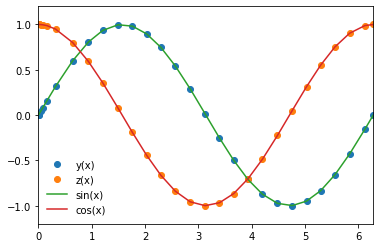

In [7]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='z(x)')
plt.plot(x,np.sin(x),label='sin(x)')
plt.plot(x,np.cos(x),label='cos(x)')
plt.xlim([0,2*np.pi])
plt.ylim([-1.2,1.2])
plt.legend(frameon=False)

## Plot the eroor

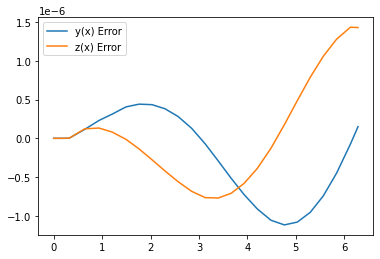

In [8]:
plt.plot(x,y[:,0]-np.sin(x), label="y(x) Error")
plt.plot(x,y[:,1]-np.cos(x), label="z(x) Error")
plt.legend()

## Ta-Da, done! This took way too long for me to figure out even with Brant's solution, hahah!